# **Initialization** 

In [2]:
import pandas as pd
import torch

### Control

In [ ]:
# Paths
RAW_DATA_FOLDER = 'raw_data'
TARGET_FILE_PATH = 'unprocessed_data'

# Flow Controls
RELOAD_RAW_DATA = False
DO_SMOTE = True
DATA = 'depression'  # Options: 'depression', 'insomnia', 'electrical_circuit'

# System variables
STATE = 42
TEST_SET_FRACTION = 0.20
MISSING_VALUES_THRESHOLD = 0.50
SAMPLES_ELECTRICAL_CIRCUIT = 5000
VERBOSE = True

# **Data Preparation**

### Merge raw data files

In [4]:
from raw_data_loader import load_raw_data

if (RELOAD_RAW_DATA):
    load_raw_data(RAW_DATA_FOLDER, TARGET_FILE_PATH)

### Preprocessing and Split

In [5]:
from preprocessing_depression import clean_and_preprocess_depression_data
from preprocessing_insomnia import clean_and_preprocess_insomnia_data
from preprocessing_electrical_circuit import gen_and_preprocess_ec_data

dataset = pd.read_csv(TARGET_FILE_PATH + '/depression_data.csv')

if DATA == 'depression':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_depression_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD)
elif DATA == 'insomnia':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_insomnia_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD)
elif DATA == 'electrical_circuit':
    ec_X_train, ec_X_test, ec_y_train, ec_y_test, ec_y_embed_train, ec_y_embed_test = gen_and_preprocess_ec_data(SAMPLES_ELECTRICAL_CIRCUIT, TEST_SET_FRACTION, STATE)
else:
    raise ValueError("Invalid dataset selected")

#TODO Fix issue with the time columns SLQ300/310/320/330 in depression and processing

Dropped 142 columns with >50.0% missing values
Shape after dropping high-missing columns: (3333, 109)
Replaced 708 special code values with NaN
Replaced 186 special code values with NaN
Ordinal columns: 27
Nominal columns: 3
Binary columns: 2
Numerical columns: 74
Object columns (excluded): 3
Total columns identified: 109


c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['SLQ300' 'SLQ310' 'SLQ320' 'SLQ330']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### Data Balancing

In [ ]:
from data_balancing import resample_training_data

if DO_SMOTE:
    X_train, y_train, y_embed_train = resample_training_data(X_train, y_train, y_embed_train, random_state=STATE)

Class distribution:
depressed
0    3136
1    3136
Name: count, dtype: int64

Class ratio: 100.000%


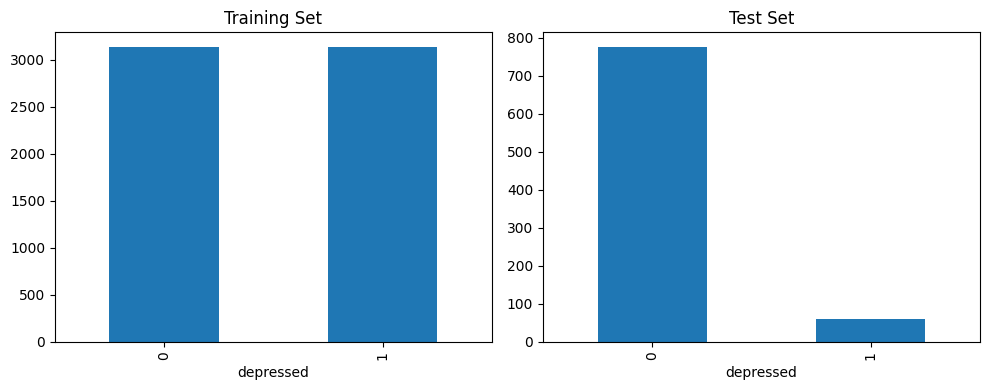

In [18]:
import matplotlib.pyplot as plt

# Check class distribution
print("Class distribution:")
print(y_train.value_counts())
print(f"\nClass ratio: {100*(y_train.value_counts()[1] / y_train.value_counts()[0]):.3f}%")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training Set')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Test Set')
plt.tight_layout()
plt.show()

# **Models**

In [9]:
from baseline_models import train_multitarget_baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### Training Bayesian Models

In [10]:
nb_model = GaussianNB()
y_pred_nb, acc_nb = train_multitarget_baseline(
                            model=nb_model,
                            is_classifier=False,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## GaussianNB Multitarget Regressor ########################################
Train MSE per embedding: [1.28794643 1.52184311 1.93702168 1.13408801 1.18383291 1.70838648
 2.40880102 4.99633291 3.36543367]
Test MSE per embedding: [1.5647482  2.29976019 1.98201439 1.4940048  1.617506   2.57913669
 3.10431655 5.82374101 4.38848921]
Average train MSE: 2.171520691609977
Average test MSE: 2.7615241140420994


### Training Random Forests

In [11]:
# Parameter
N_ESTIMATORS = 100

In [12]:
rf_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=STATE, n_jobs=-1)
y_pred_rf, mse_rf = train_multitarget_baseline(
                                    model=rf_model, 
                                    is_classifier=False, 
                                    X_train=X_train, 
                                    X_test=X_test, 
                                    y_embed_train=y_embed_train, 
                                    y_embed_test=y_embed_test,
                                    verbose=VERBOSE)



 ######################################## RandomForestRegressor Multitarget Regressor ########################################
Train MSE per embedding: [0.05254971 0.04059981 0.06717875 0.05249405 0.05698229 0.04679115
 0.04532655 0.03131475 0.01530638]
Test MSE per embedding: [0.67131055 0.61219664 0.86782026 0.70679341 0.75340887 0.66965755
 0.66508549 0.45292374 0.22740372]
Average train MSE: 0.04539371456916105
Average test MSE: 0.6251778044231282


### Training Logistic Models

In [14]:
# Parameters
MAX_ITERATIONS = 1000

In [15]:
log_model = LogisticRegression(max_iter=MAX_ITERATIONS, class_weight='balanced', random_state=STATE)
y_pred_log, acc_log = train_multitarget_baseline(
                            model=log_model,
                            is_classifier=True,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## LogisticRegression Multitarget Classifier ########################################
Train accuracy per embedding: [0.62085459 0.66358418 0.55117985 0.57509566 0.57621173 0.60220026
 0.63042092 0.64126276 0.69164541]
Test accuracy per embedding: [0.48920863 0.53717026 0.37170264 0.40767386 0.49880096 0.5647482
 0.54676259 0.66906475 0.73980815]
Average train accuracy: 0.6169394841269841
Average test accuracy: 0.5361044497735146


### Train Split MLP

In [17]:
from split_model import train_split_model
torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test )

9 109


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### Train Joint MLP

In [16]:
from joint_model import train_joint_model

train_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test )



 ######################################## Joint MLP  ########################################
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       775
           1       0.00      0.00      0.00        59

    accuracy                           0.93       834
   macro avg       0.46      0.50      0.48       834
weighted avg       0.86      0.93      0.90       834

Confusion matrix:
 [[775   0]
 [ 59   0]]


c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jaspe\Documents\Github_projects\DSAIT4020-A2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _